pip install tqdm
pip install pillow
pip install image
pip install keras
pip install imblearn

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# Load data and preprocessing

In [2]:
train_dataset = pd.read_csv('../../plant-pathology-2020-fgvc7/train.csv')
test_dataset = pd.read_csv('../../plant-pathology-2020-fgvc7/test.csv')

In [3]:
print("-----------------------TRAIN-------------------------- \n :",train_dataset.head())
print("\n Shape : ",train_dataset.shape)

-----------------------TRAIN-------------------------- 
 :   image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

 Shape :  (1821, 5)


In [4]:
print("-----------------------TEST-------------------------- \n :",test_dataset.head())
print("\n Shape : ",test_dataset.shape)

-----------------------TEST-------------------------- 
 :   image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

 Shape :  (1821, 1)


In [5]:
train_dataset.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
targets = train_dataset[['healthy', 'multiple_diseases', 'rust', 'scab']]

 Split the data into train and validation sets, then take a quick look at their make up.

In [7]:
train, validation = train_test_split(train_dataset, test_size=0.2)

Display a picture

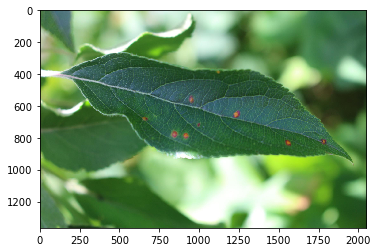

In [8]:
# Retour d'une image de façon aléatoire
randImg = np.random.randint(1820)
img = mpimg.imread(f'../../plant-pathology-2020-fgvc7/images/Train_{randImg}.jpg')
imgplot = plt.imshow(img)

In [9]:
print(train_dataset.shape[0])

1821


On va stocker les images sous formes de données brutes au format LIB

In [10]:
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

size = 64
nb_img = train_dataset.shape[0]
path = '../../plant-pathology-2020-fgvc7/images/'
train_images = np.ndarray(shape=(train_dataset.shape[0], size, size, 3))
test_images = np.ndarray(shape=(test_dataset.shape[0], size, size, 3))

# tqdm pour avoir une barre dévolution
for i in tqdm(range(nb_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.float32(img_to_array(img))
    
for i in tqdm(range(nb_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  test_images[i] = np.float32(img_to_array(img))

Using TensorFlow backend.


In [11]:
print("Train_images :",train_images.shape)
print("Test_images :",test_images.shape)

Train_images : (1821, 64, 64, 3)
Test_images : (1821, 64, 64, 3)


Réequilibre des images pour chaque dim

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(np.reshape(train_images, (-1, size * size * 3)), targets.to_numpy())
x_res = x_res.reshape((-1, size, size, 3))

In [13]:
print(x_res.shape)
print(y_res.shape)

(2488, 64, 64, 3)
(2488, 4)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2)

In [15]:
from tensorflow.keras.layers import * # Convolution2D, MaxPooling, Flatten, Dense
from tensorflow.keras.models import * # Sequential
from tensorflow.keras.regularizers import * # 
from tensorflow.keras.optimizers import * # 

Préparation des données avec un ImageDataGenerator

In [16]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size= 512
    )

test_set = test_datagen.flow(
    x = x_test,
    y = y_test,
    batch_size= 512
    )

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1990, 64, 64, 3)
(1990, 4)
(498, 64, 64, 3)
(498, 4)


In [18]:
x_train = x_train.reshape((x_train.shape[0], 64, 192))
x_test = x_test.reshape((x_test.shape[0], 64, 192))

In [19]:
# New train_labels
train_labels = np.ndarray(shape=(1990, 1), dtype=int, order='F')
i = 0
while i<train_labels.shape[0]:
    train_labels.put(i,np.argmax(y_train[i]))
    i=i+1

In [20]:
train_labels.shape

(1990, 1)

In [21]:
x_train = x_train/255
x_test = x_test/255

## Modèle RNN (Lstm)

Structure du LSTM

In [22]:
class Lstm:

    def __init__(self):
        self.name = "lstm"
        self.nb_layers = 3
        self.units = 50
        self.activation = 'tanh'
        self.output_activation = 'softmax'
        self.recurrent_activation = 'sigmoid'
        self.dropout_value = 0.0
        self.kernel_regularizer = None
        self.recurrent_regularizer = None
        self.output_regularizer = None
        self.l1_value = 0.0
        self.l2_value = 0.0
        self.loss = 'sparse_categorical_crossentropy'
        self .optimizer = 'Adam'
        self.metrics = ['sparse_categorical_accuracy']

In [23]:
def create_lstm(lstm_struct: Lstm):

    input_tensor = Input((64, 192))

    #Ici on va commencer à creer et empiler les différentes couches pour de meilleur prédictions
    lstm_tensor = input_tensor
    for i in range(lstm_struct.nb_layers - 1):
        lstm_tensor = LSTM(units= lstm_struct.units,
                           kernel_regularizer=lstm_struct.kernel_regularizer,
                           recurrent_regularizer=lstm_struct.recurrent_regularizer,
                           dropout=lstm_struct.dropout_value,
                           return_sequences=True
                           )(lstm_tensor)

    #Return_sequences prend False ici 
    lstm_tensor = LSTM(units=lstm_struct.units,
                       kernel_regularizer=lstm_struct.kernel_regularizer,
                       recurrent_regularizer=lstm_struct.recurrent_regularizer,
                       dropout=lstm_struct.dropout_value,
                       return_sequences=False
                       )(lstm_tensor)

    output_tensor = Dense(4, activation=lstm_struct.output_activation, kernel_regularizer=lstm_struct.output_regularizer)(lstm_tensor)

    model = Model(input_tensor, output_tensor)

    model.compile(loss=lstm_struct.loss, optimizer=lstm_struct.optimizer, metrics=lstm_struct.metrics)

    return model

In [24]:
struct = Lstm()
model = create_lstm(struct)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 192)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 50)            48600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 89,204
Trainable params: 89,204
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.fit(x_train, 
          train_labels, 
          epochs=32,
          batch_size=400)

Train on 1990 samples
Epoch 1/100
1990/1990 [==============================] - 7s 4ms/sample - loss: 1.3923 - sparse_categorical_accuracy: 0.2447
Epoch 2/100
1990/1990 [==============================] - 0s 139us/sample - loss: 1.3667 - sparse_categorical_accuracy: 0.3296
Epoch 3/100
1990/1990 [==============================] - 0s 138us/sample - loss: 1.3464 - sparse_categorical_accuracy: 0.3477
Epoch 4/100
1990/1990 [==============================] - 0s 137us/sample - loss: 1.3305 - sparse_categorical_accuracy: 0.3608
Epoch 5/100
1990/1990 [==============================] - 0s 136us/sample - loss: 1.3142 - sparse_categorical_accuracy: 0.3678
Epoch 6/100
1990/1990 [==============================] - 0s 137us/sample - loss: 1.2979 - sparse_categorical_accuracy: 0.3854
Epoch 7/100
1990/1990 [==============================] - 0s 135us/sample - loss: 1.2784 - sparse_categorical_accuracy: 0.4000
Epoch 8/100
1990/1990 [==============================] - 0s 138us/sample - loss: 1.2619 - sparse_c

1990/1990 [==============================] - 0s 138us/sample - loss: 0.3488 - sparse_categorical_accuracy: 0.8784
Epoch 66/100
1990/1990 [==============================] - 0s 133us/sample - loss: 0.3469 - sparse_categorical_accuracy: 0.8683
Epoch 67/100
1990/1990 [==============================] - 0s 136us/sample - loss: 0.3390 - sparse_categorical_accuracy: 0.8769
Epoch 68/100
1990/1990 [==============================] - 0s 135us/sample - loss: 0.3188 - sparse_categorical_accuracy: 0.8829
Epoch 69/100
1990/1990 [==============================] - 0s 133us/sample - loss: 0.3529 - sparse_categorical_accuracy: 0.8633
Epoch 70/100
1990/1990 [==============================] - 0s 135us/sample - loss: 0.3459 - sparse_categorical_accuracy: 0.8714
Epoch 71/100
1990/1990 [==============================] - 0s 136us/sample - loss: 0.3258 - sparse_categorical_accuracy: 0.8839
Epoch 72/100
1990/1990 [==============================] - 0s 135us/sample - loss: 0.3359 - sparse_categorical_accuracy: 0.87